In this practical session we will see how to compute documents embeddings and use them for text classification.


1.  In the first part we will use bag of words methods
2.  In the second part we will explore word embeddings methods
3. In the last part you will play with transformers

During all the practical session, you will work on the same dataset [AG's corpus of news article] which will help you to fairly compare each approches.

*AG News (AG’s News Corpus) is a subdataset of [AG's corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The AG News contains 30,000 training and 1,900 test samples per class.*  

Let's first download the dataset:

In [1]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv 2>&1
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv 2>&1

--2025-03-24 21:21:11--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2025-03-24 21:21:11--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.1s    

2025-03-24 21:21:14 (254 MB/s) - ‘train.csv’ saved [29470338/29470338]

--20

The following code snippet will load the dataset and incorporate the label names into a new column.

In [2]:
import pandas as pd

traindf = pd.read_csv('train.csv', names=["label", "title", "text"]).sample(2000)
testdf = pd.read_csv('test.csv', names=["label", "title", "text"]).sample(1000)

traindf['label'] = traindf['label'] -1
traindf['label_name'] = traindf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf['label'] = testdf['label'] -1
testdf['label_name'] = testdf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf

label                                              title  \
4993      1  Premier League charges Villa manager with ille...   
6796      2             Setback for asbestos settlement at ABB   
6708      3                                  After the X Prize   
4823      1  New Englanders greet the day with wings on the...   
4126      1                Veterans face quandary with Pistons   
...     ...                                                ...   
5273      2  S.E.C. Is Said to Examine Stock Pricing by Big...   
6362      2     Spaniards to run Luton airport after 551m deal   
3245      0                         HK democrats to take seats   
4048      3  South Korea to Pick Country's First 2 Astronau...   
5019      2  Steenland: Northwest Joins Southwest In Raidin...   

                                                   text label_name  
4993  The Premier League has charged Aston Villa man...     Sports  
6796  ABB said it was aware of the ruling, but remai...   Business  
6708  Just weeks before the historic second flight o...   Sci/Tech  
4823  In a Framingham coffee shop yesterday morning,...     Sports  
4126  Antonio McDyess and Derrick Coleman understood...     Sports  
...                                                 ...        ...  
5273  The Securities and Exchange Commission is look...   Business  
6362  Luton, Cardiff and Belfast International airpo...   Business  
3245  A new crop of Hong Kong democrats are due to b...      World  
4048  Reuters - South Korea will pick its first two\...   Sci/Tech  
5019  Gnawed by Northwest. Joining an apparent feedi...   Business  

[1000 rows x 4 columns]


**Begin with Initial Exploration:**

To kick off our analysis, let's start with a bit of exploration. We'll utilize the Wordcloud library and follow the example provided in the [documentation](https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py) to create a visualization of the most common words in our corpus.

To get started, you can concatenate all the documents into a single text. A straightforward way to do this is by using the `"".join()` function on a list of text...


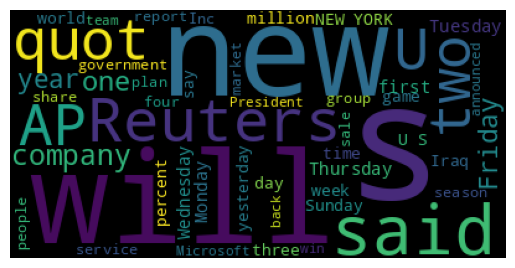

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = " ".join(traindf.text.values)
wordcloud = WordCloud(background_color = 'black', max_words = 50).generate(corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

By default, Wordcloud automatically excludes common English words such as "and," "or," "the," and "a." However, you can customize this list of excluded words to suit your needs.

If you're looking for a powerful library for natural language processing, consider using [NLTK](https://www.nltk.org/). NLTK provides several lists of stopwords that can be used to clean text data.

Even though using NLTK stopwords may not significantly alter the results, let's go ahead and provide Wordcloud with a custom list of stopwords sourced from NLTK.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


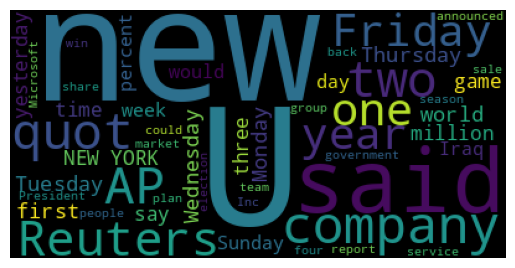

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(background_color = 'black', stopwords = stop_words, max_words = 50).generate(corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

Now, plot a different wordcloud for every category in the dataset.  
Are you capable of predicting the categories given only these wordclouds?

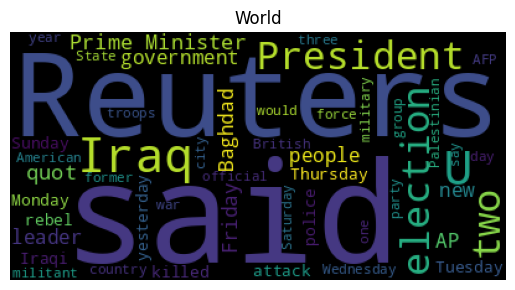

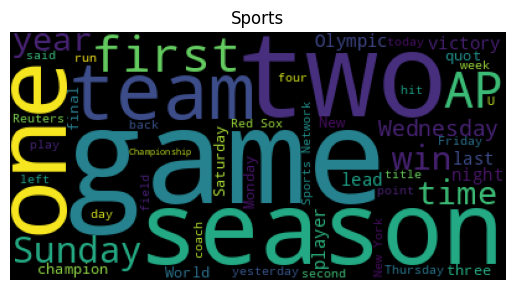

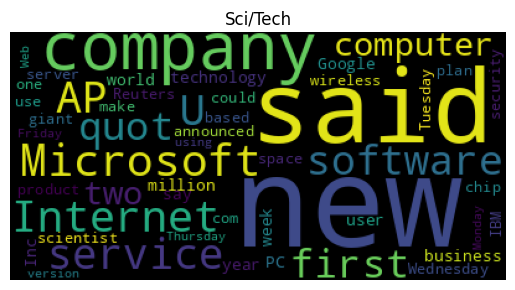

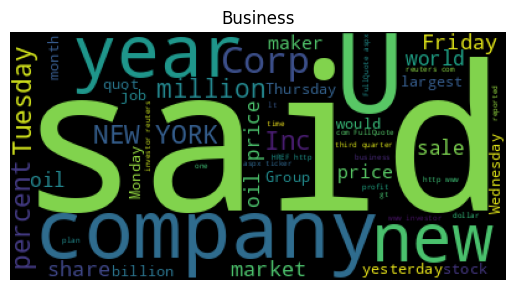

In [5]:
for label in traindf.label_name.unique():
  plt.figure()
  corpus = " ".join(traindf[traindf.label_name == label].text.values)
  wordcloud = WordCloud(background_color = 'black', stopwords = stop_words, max_words = 50).generate(corpus)
  plt.imshow(wordcloud)
  plt.title(label)
  plt.axis("off")

# Bag-of-Words (BoW)

In this section, we will train various models to predict the category of news articles. One of the initial approaches we'll explore is called the "**bag of words**" (BoW) method.

BoW methods represent documents by counting or calculating statistics on the words present within them. Once the bag-of-words is computed, documents are transformed into vectors, with each dimension corresponding to a word/token in the vocabulary of the corpus.

To start, vectorize your documents using term frequencies.   
You can refer to the [documentation of scikit-learn's CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to encode the **text column** of your training set.


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
train_count_matrix = vectorizer.fit_transform(traindf.text)

The ```vocabulary_``` argument of your vectorizer contains a dictionary with all the tokens and their corresponding index in the bag-of-words.  
How many unique tokens compose your bag-of-words?

In [7]:
len(vectorizer.vocabulary_)

10219

You can also use the ```get_feature_names_out()``` method to get the list of identified tokens:

In [8]:
vectorizer.get_feature_names_out()

array(['00', '000', '01', ..., 'zone', 'zurich', 'zvonareva'],
      dtype=object)

Now choose a classification method from scikit-learn and train it to classify news article.  
Print the classification score of your model on the training set.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_count_matrix, traindf.label)
print(f"Model score: {rf.score(train_count_matrix, traindf.label)}")

Model score: 1.0


Now use the ```transform``` method from your vectorizer on the testing set and print the score obtained by your model on the testing set.  
Your model is probably overfitting a lot.  
Plot a [consusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to see where your model makes the most mistakes.

In [10]:
test_count_matrix = vectorizer.transform(testdf.text)
print(f"Model score: {rf.score(test_count_matrix, testdf.label)}")

Model score: 0.78


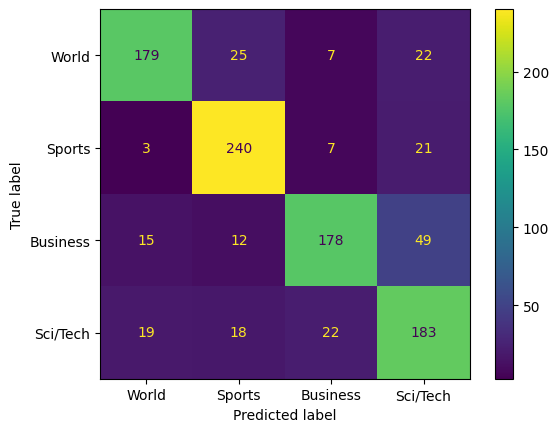

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = rf.predict(test_count_matrix)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

Play with some of the vectorizer hyper-parameters to see whether you can improve the perfomance of your classifier on the testing set.  
Try adding stopwords or changing the ngram_range...

In [12]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
train_count_matrix = vectorizer.fit_transform(traindf.text)
rf = RandomForestClassifier()
rf.fit(train_count_matrix, traindf.label)
test_count_matrix = vectorizer.transform(testdf.text)
print(f"Model score: {rf.score(test_count_matrix, testdf.label)}")

Model score: 0.805


Once you are satisfied with the model's performance or find that it's not improving further, you can proceed to plot a [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) visualization of your training representations, using different colors to represent labels.

In particular, compare the t-SNE representations computed with and without stopwords. What observations do you make from this comparison?


<Axes: >

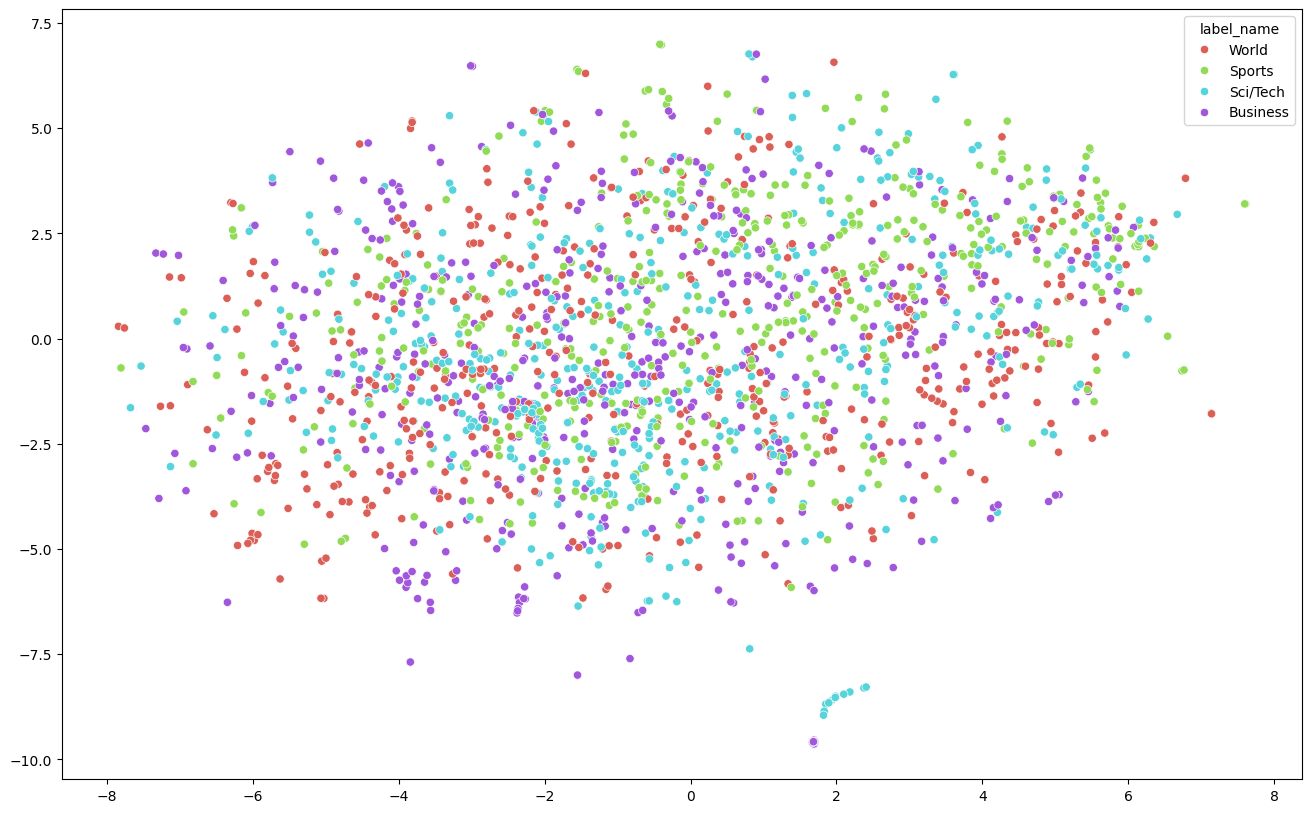

<Figure size 640x480 with 0 Axes>

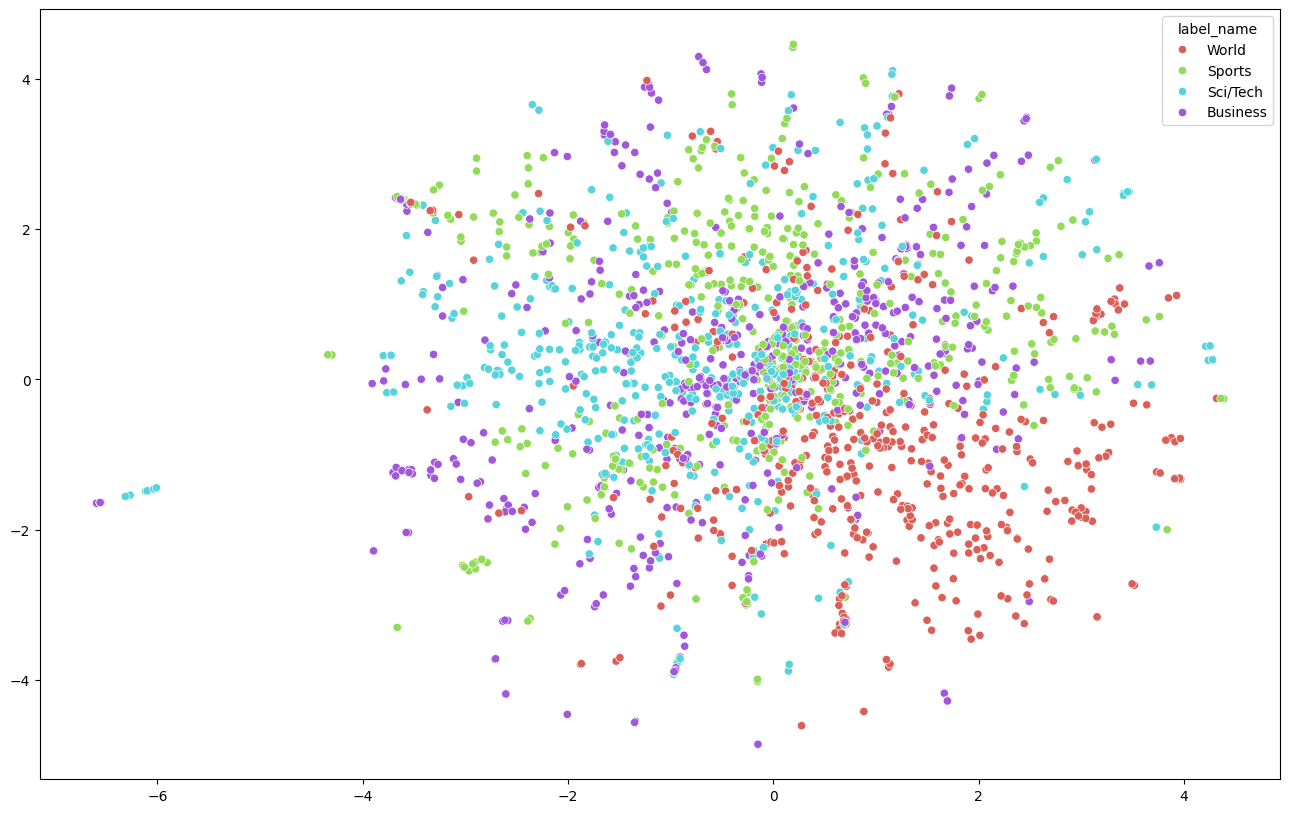

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

vectorizer = CountVectorizer()
train_count_matrix = vectorizer.fit_transform(traindf.text)

tsne = TSNE(n_components=2, init='random')
X_tsne = tsne.fit_transform(train_count_matrix)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=traindf.label_name,
    palette=sns.color_palette("hls", 4),
    legend="full")

plt.figure()

vectorizer = CountVectorizer(stop_words='english')
train_count_matrix = vectorizer.fit_transform(traindf.text)

tsne = TSNE(n_components=2, init='random')
X_tsne = tsne.fit_transform(train_count_matrix)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=traindf.label_name,
    palette=sns.color_palette("hls", 4),
    legend="full")

Now, let's explore a second vectorization strategy, which is more efficient than pure term frequency: TF-IDF (Term Frequency-Inverse Document Frequency).

**What's the difference compared to the previous method?**

TF-IDF takes into account not only the frequency of terms in a document but also their importance in the entire corpus. It assigns higher weights to terms that are frequent in a document but rare across all documents. This helps in distinguishing important terms from common ones.

To implement TF-IDF vectorization, you can use [scikit-learn's `TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Once you've vectorized the documents, train a classification algorithm to classify them. Afterward, print the score obtained on the testing set and the corresponding confusion matrix.


Model score on training data: 1.00
Model score on test data: 0.785


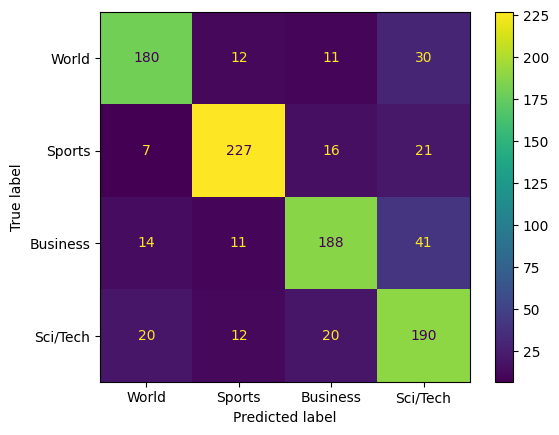

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_tfidf_matrix = tfidf.fit_transform(traindf.text)

rf = RandomForestClassifier()
rf.fit(train_tfidf_matrix, traindf.label)
print(f"Model score on training data: {rf.score(train_tfidf_matrix, traindf.label):.2f}")
test_tfidf_matrix = tfidf.transform(testdf.text)
print(f"Model score on test data: {rf.score(test_tfidf_matrix, testdf.label)}")

predictions = rf.predict(test_tfidf_matrix)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

Plot a t-SNE of the representations obtained using TF-IDF.

<Axes: >

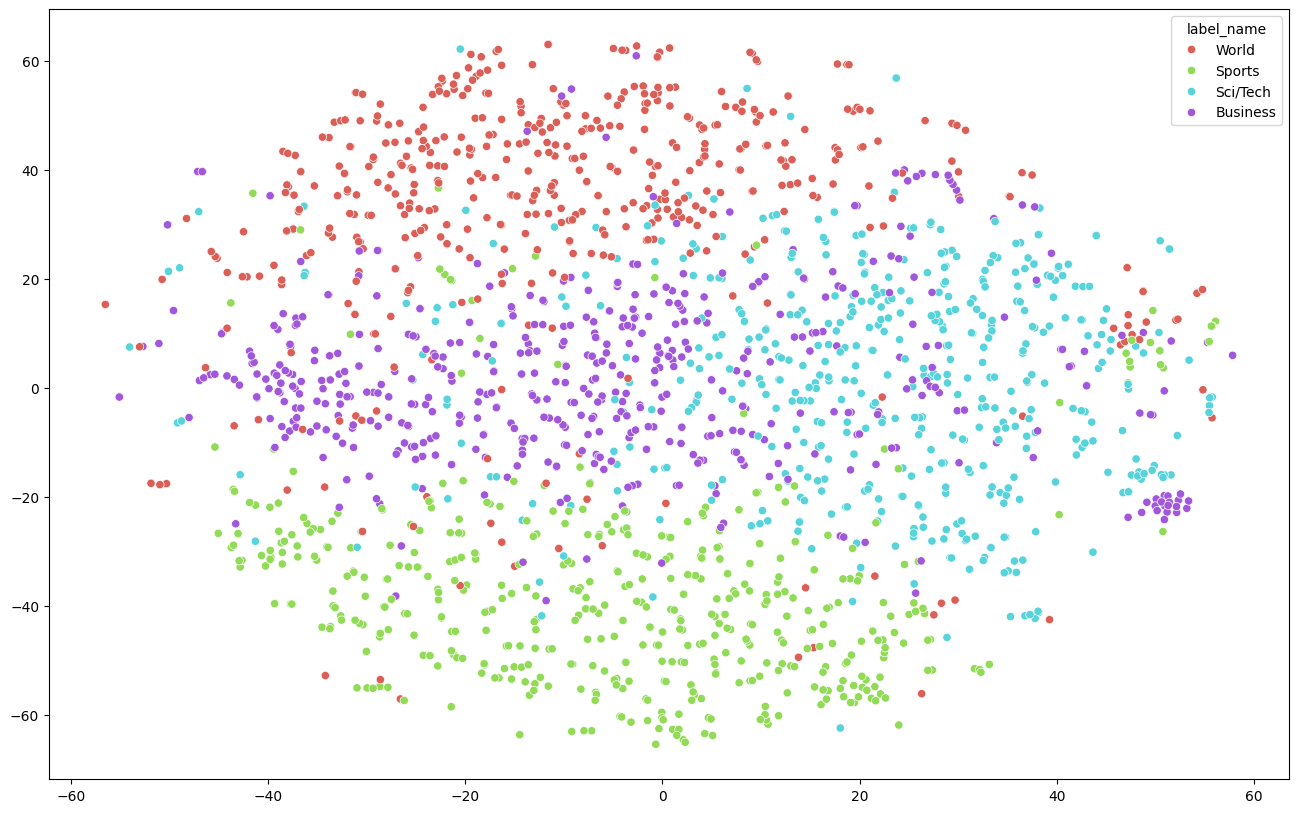

In [15]:
tsne = TSNE(n_components=2, init='random')
X_tsne = tsne.fit_transform(train_tfidf_matrix)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=traindf.label_name,
    palette=sns.color_palette("hls", 4),
    legend="full")

Both the ```TfidfVectorizer``` and ```CountVectorizer``` use a default strategy to create a token given a text using whitespaces and punctuations as separators.  
It is possible to provide custom __tokenizers__ to these vectorizers.  
Here we will use NLTK to build a more powerful tokenizer that will:

*   Revmove stop words
*   Convert all texts to lowercase
*   Ignore punctuations symbols
*   Only consider letters
*   Perform Stemming on every token



In [18]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords
import re


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
# Download stopwords list

stop_words = set(stopwords.words('english'))

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        doc = doc.lower()
        return [self.stemmer.stem(t) for t in word_tokenize(re.sub("[^a-z' ]", "", doc)) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Print an example of text from the dataset and the corresponding tokens computed by the tokenizer.

In [19]:
s = traindf.text.values[0][:100]
print(s)
print(tokenizer(s))

AP - U.S. aircraft bombed a suspected rebel safehouse Thursday in the insurgent stronghold of Falluj
['ap', 'us', 'aircraft', 'bomb', 'a', 'suspect', 'rebel', 'safehous', 'thursday', 'in', 'the', 'insurg', 'stronghold', 'of', 'falluj']


Now provide the tokenizer to the a ```TfidfVectorizer``` and repeat the entire process.  
Does it improves the testing performance?  
Tips: you should also provide a tokenized version of the stopwords since we apply stemming on all tokens.

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model score on training data: 1.00
Model score on test data: 0.808


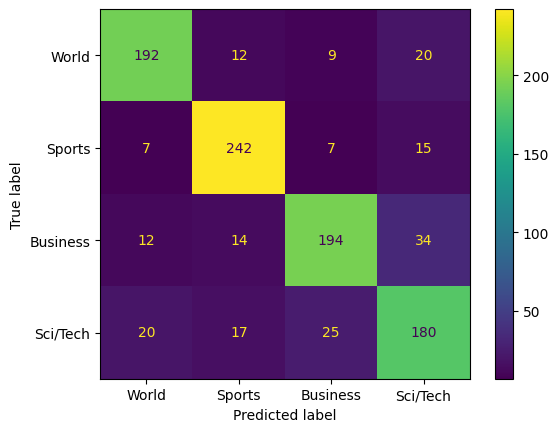

<Axes: >

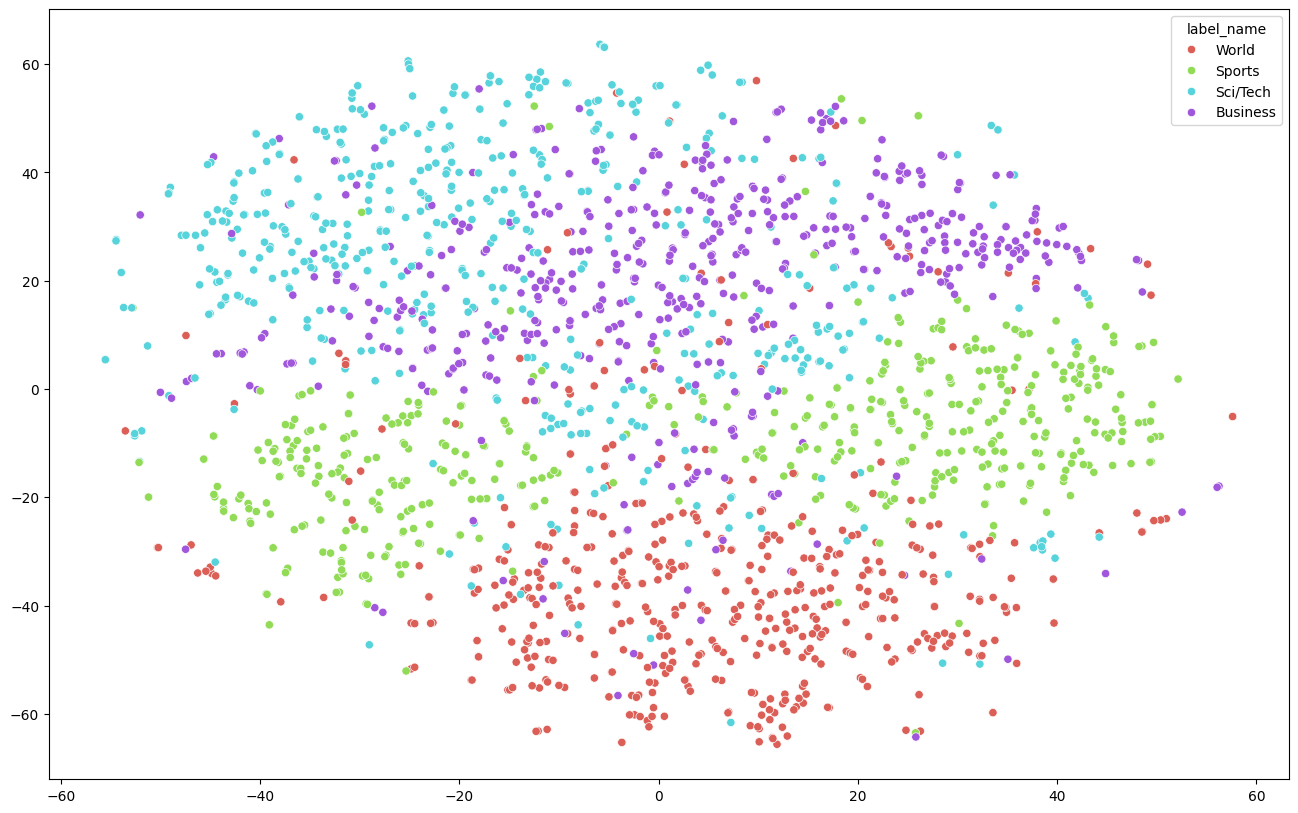

In [20]:
token_stop = tokenizer(' '.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer)

train_tfidf_matrix = tfidf.fit_transform(traindf.text)

rf = RandomForestClassifier()
rf.fit(train_tfidf_matrix, traindf.label)
print(f"Model score on training data: {rf.score(train_tfidf_matrix, traindf.label):.2f}")
test_tfidf_matrix = tfidf.transform(testdf.text)
print(f"Model score on test data: {rf.score(test_tfidf_matrix, testdf.label)}")

predictions = rf.predict(test_tfidf_matrix)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

tsne = TSNE(n_components=2, init='random')
X_tsne = tsne.fit_transform(train_tfidf_matrix)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=traindf.label_name,
    palette=sns.color_palette("hls", 4),
    legend="full")

It is also possible to combine bag-of-words features with other features manually computed.  
The following code computes some new features on all documents.

In [21]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_words(string):
    return sum(map(str.isupper, string))

def count_capital_words(text):
  return sum(map(str.isupper,text.split()))

def count_punctuations(text):
  count = 0
  for i in range (0, len (text)):
    if text[i] in ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?"):
        count = count + 1;
  return  count

def count_sentences(text):
    return len(nltk.sent_tokenize(text))

def count_unique_words(text):
    return len(set(text.split()))

for df in [traindf, testdf]:
  df['count_chars'] = df.text.apply(lambda s: count_chars(s))
  df['count_words'] = df.text.apply(lambda s: count_words(s))
  df['count_capital_words'] = df.text.apply(lambda s: count_capital_words(s))
  df['count_capital_words'] = df.text.apply(lambda s: count_capital_words(s))
  df['count_punctuations'] = df.text.apply(lambda s: count_punctuations(s))
  df['count_sentences'] = df.text.apply(lambda s: count_sentences(s))
  df['count_unique_words'] = df.text.apply(lambda s: count_unique_words(s))
  df['avg_wordlength'] = df['count_chars']/df['count_words']
  df['avg_sentlength'] = df['count_words']/df['count_sentences']

Using a [```ColumnTransformer```](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) it is possible to combine all the features.

In [22]:
from sklearn.compose import ColumnTransformer

columns_to_keep = ['text', 'count_chars', 'count_words',
       'count_capital_words', 'count_punctuations',
       'count_unique_words', 'count_sentences', 'avg_wordlength',
       'avg_sentlength']

column_trans = ColumnTransformer(
    [('categories', TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer), 'text')],
    remainder='passthrough', verbose_feature_names_out=False)

X_train = column_trans.fit_transform(traindf[columns_to_keep])
X_test = column_trans.transform(testdf[columns_to_keep])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Unfortunately, in our particular case, these features do not seem to lead to any improvement in testing performance.  
However, it's important to note that in different tasks, such as spam detection, these features can have a more pronounced and positive impact.


Model score on training data: 1.00
Model score on test data: 0.799


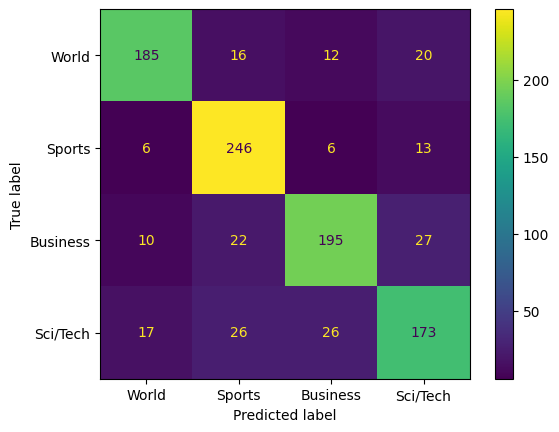

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, traindf.label)
print(f"Model score on training data: {rf.score(X_train, traindf.label):.2f}")
print(f"Model score on test data: {rf.score(X_test, testdf.label)}")

predictions = rf.predict(X_test)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

# Word Vectorization with Gensim and GloVe

In this section, we will explore another vectorization technique introduced during our course lectures: word vectorization. Specifically, we will use the Gensim library to work with pre-computed word embeddings.

To begin, we'll utilize pre-computed word embeddings called [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe, which stands for "Global Vectors for Word Representation," is an innovative method for generating word embeddings.

GloVe embeddings are unique because they capture not only the local context of words within sentences but also the global context of words across the entire corpus. This is achieved through a specific training objective.

During the training of GloVe embeddings, the model aims to learn word representations in such a way that the dot product between the vectors of two words corresponds to the logarithm of their co-occurrence probability in the corpus. In other words, GloVe embeddings optimize to represent words in a way that reflects how often they appear together in the same context. This results in vector representations that capture meaningful semantic relationships between words.


In [24]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip > /dev/null 2>&1

--2025-03-24 21:31:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-24 21:31:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.96MB/s    in 25m 59s 

2025-03-24 21:58:22 (540 KB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [31]:
!pip install --upgrade gensim

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [1]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = ('glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

<ipython-input-1-5ec840f65c73>:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


The model is a mapping between words and their vector representations.  
Here is an exemple of representation:

In [2]:
model['apple']

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

It also has usefull methods to explore the  vocabulary's embeddings.  
Here are some examples to find the most similar words in the embedding space.   
Try with some other words and look if the most similar words seem plausibles.

In [3]:
model.most_similar('zuckerberg')

[('facebook', 0.6360229849815369),
 ('linkedin', 0.6329243779182434),
 ('myspace', 0.6072915196418762),
 ('saverin', 0.6035687923431396),
 ('dewolfe', 0.5960866808891296),
 ('friendster', 0.593579113483429),
 ('twitter', 0.5506225228309631),
 ('salzman', 0.5457445383071899),
 ('zynga', 0.5324303507804871),
 ('berkowitz', 0.515297532081604)]

In [4]:
model.most_similar('google')

[('yahoo', 0.8637358546257019),
 ('microsoft', 0.8104099035263062),
 ('web', 0.7629812359809875),
 ('aol', 0.7571687698364258),
 ('facebook', 0.7516582012176514),
 ('internet', 0.738322377204895),
 ('ebay', 0.7163310647010803),
 ('netscape', 0.7149452567100525),
 ('msn', 0.7122776508331299),
 ('online', 0.6866507530212402)]

In [5]:
model.most_similar('intelligence')

[('cia', 0.742180585861206),
 ('information', 0.7210196852684021),
 ('security', 0.6963101625442505),
 ('fbi', 0.696229100227356),
 ('military', 0.6934822201728821),
 ('secret', 0.6893364191055298),
 ('counterterrorism', 0.676262617111206),
 ('pentagon', 0.6651185750961304),
 ('defense', 0.6564568281173706),
 ('agents', 0.6406551599502563)]

In [6]:
model.most_similar(negative='network')

[('weizhou', 0.5158531069755554),
 ('rozman', 0.5127044916152954),
 ('shuckburgh', 0.5078345537185669),
 ('achilleos', 0.5055078864097595),
 ('mechthild', 0.5052392482757568),
 ('logudoro', 0.5041956305503845),
 ('evangelia', 0.5031293630599976),
 ('aygun', 0.502865731716156),
 ('pinney', 0.5015519261360168),
 ('marizza', 0.5008760094642639)]

An other cool feature of Word2Vec is the possibility to perform analogies.  
The most famous example is certainly king - man + woman = queen.  
Try to find other working analogies.

In [7]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7699


In [8]:
result = model.most_similar(positive=['paris', 'spain'], negative=['france'])
print("{}: {:.4f}".format(*result[0]))

madrid: 0.8061


In [9]:
result = model.most_similar(positive=['clinton', 'republican'], negative=['democrat'])
print("{}: {:.4f}".format(*result[0]))

bush: 0.8654


In [10]:
result = model.most_similar(positive=['beer', 'france'], negative=['usa'])
for i in range(3):
  print("{}: {:.4f}".format(*result[i]))

champagne: 0.5996
wine: 0.5771
bordeaux: 0.5768


The following code plots a PCA or t-SNE representation of a list of words.  
Use this method with your own list of words to see wether similar words are close to each other in the embedding space.

In [13]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def plot_embeddings(model, words, reduction='pca'):
    word_vectors = np.array([model[w] for w in words])
    if reduction == PCA:
      reductor = PCA(n_components=2)
    elif reduction == "tsne":
      reductor = TSNE(2, perplexity=20)
    X = reductor.fit_transform(word_vectors)
    plt.figure(figsize=(12,12))
    plt.scatter(X[:,0], X[:,1])
    for word, x in zip(words, X):
        plt.text(x[0]+0.05, x[1]+0.05, word)


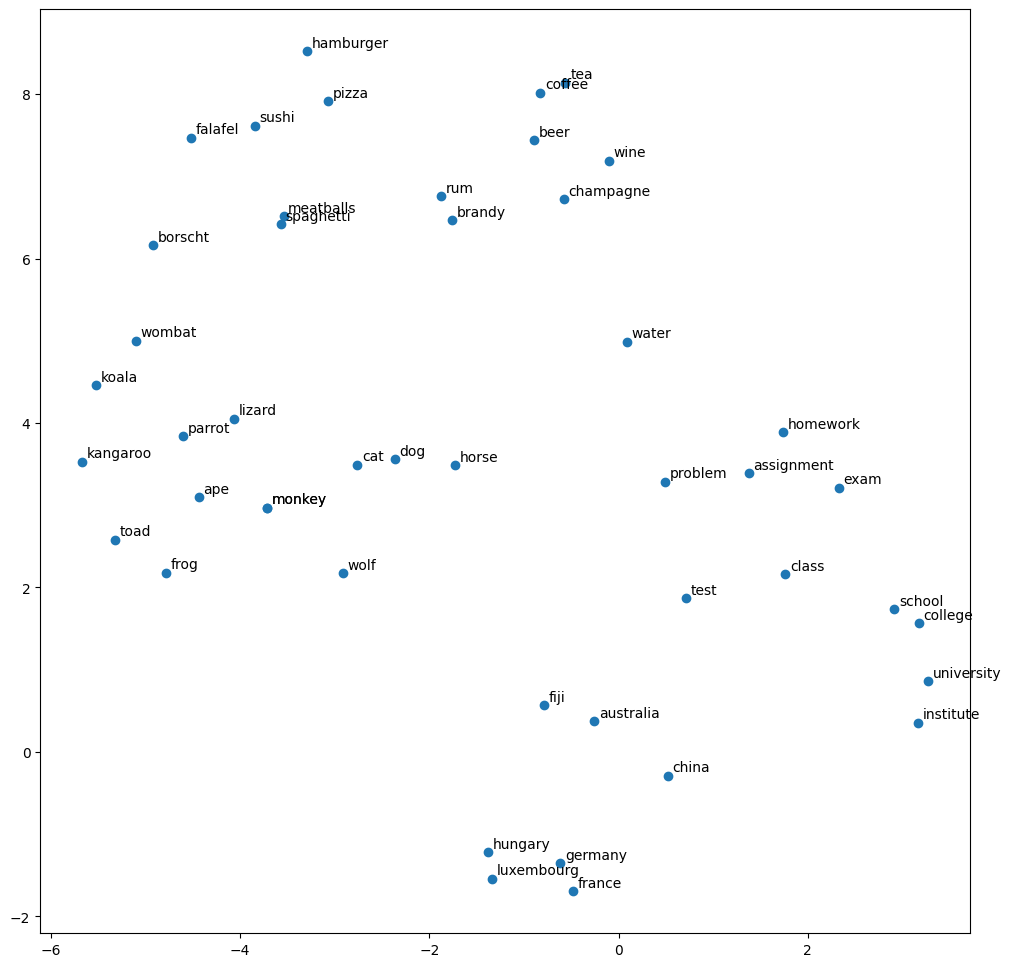

In [14]:
word_list = ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute']

plot_embeddings(model, words=word_list, reduction='tsne')

We will now use these pre-computed embeddings to build the document representations.  
A simple way to compute a document representation from word embeddings consists in computing the mean or the sum of all the document's word embeddings.  
Here, since the documents do not have the same length, it is preferable to use the mean.  
Fill in the following code to compute the mean embeddings of all documents.  
Since this process is a little bit long, we will use a limited amount of documents during the practical session. Nonetheless, feel free to try with the complete dataset at home.  

In [16]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

traindf = pd.read_csv('train.csv', names=["label", "title", "text"]).sample(1000)
testdf = pd.read_csv('test.csv', names=["label", "title", "text"]).sample(200)

traindf['label'] = traindf['label'] -1
traindf['label_name'] = traindf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf['label'] = testdf['label'] -1
testdf['label_name'] = testdf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})

def compute_mean_embeddings(s, model, words_list, dim=100):
  s = s.lower()
  emb_list = [model[w] for w in s if w in words_list]
  if emb_list != []:
    return np.mean(emb_list, axis=0)
  else:
    return np.zeros(dim)

words_list = model.index_to_key
traindf['mean_embeddings'] = traindf.text.progress_apply(lambda s: compute_mean_embeddings(s, model, words_list))
testdf['mean_embeddings'] = testdf.text.progress_apply(lambda s: compute_mean_embeddings(s, model, words_list))

100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


The following code extracts the computed embeddings from the dataframe.  
Use these to train a model to predict the article category.  
Print your testing performance and plot a confusion matrix.  
The results may be a little bit disappointing. Any idea why?

Model score on training data: 0.58
Model score on test data: 0.435


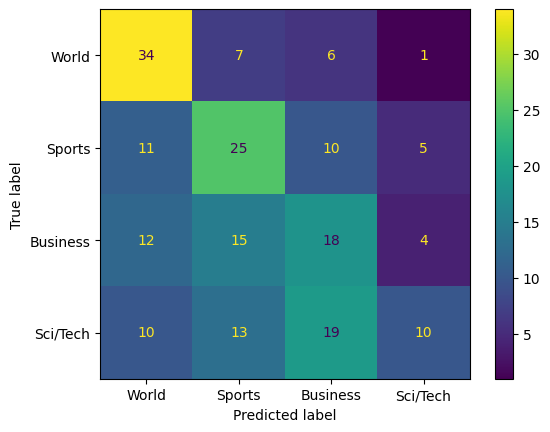

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train = np.vstack(traindf['mean_embeddings'].values)
X_test = np.vstack(testdf['mean_embeddings'].values)

rf = RandomForestClassifier(min_samples_leaf=10, max_depth=3)
rf.fit(X_train, traindf.label)
print(f"Model score on training data: {rf.score(X_train, traindf.label):.2f}")
print(f"Model score on test data: {rf.score(X_test, testdf.label)}")

predictions = rf.predict(X_test)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

Plot a t-SNE of the computed embeddings.  
Does it look like good representations to classify documents?

<Axes: >

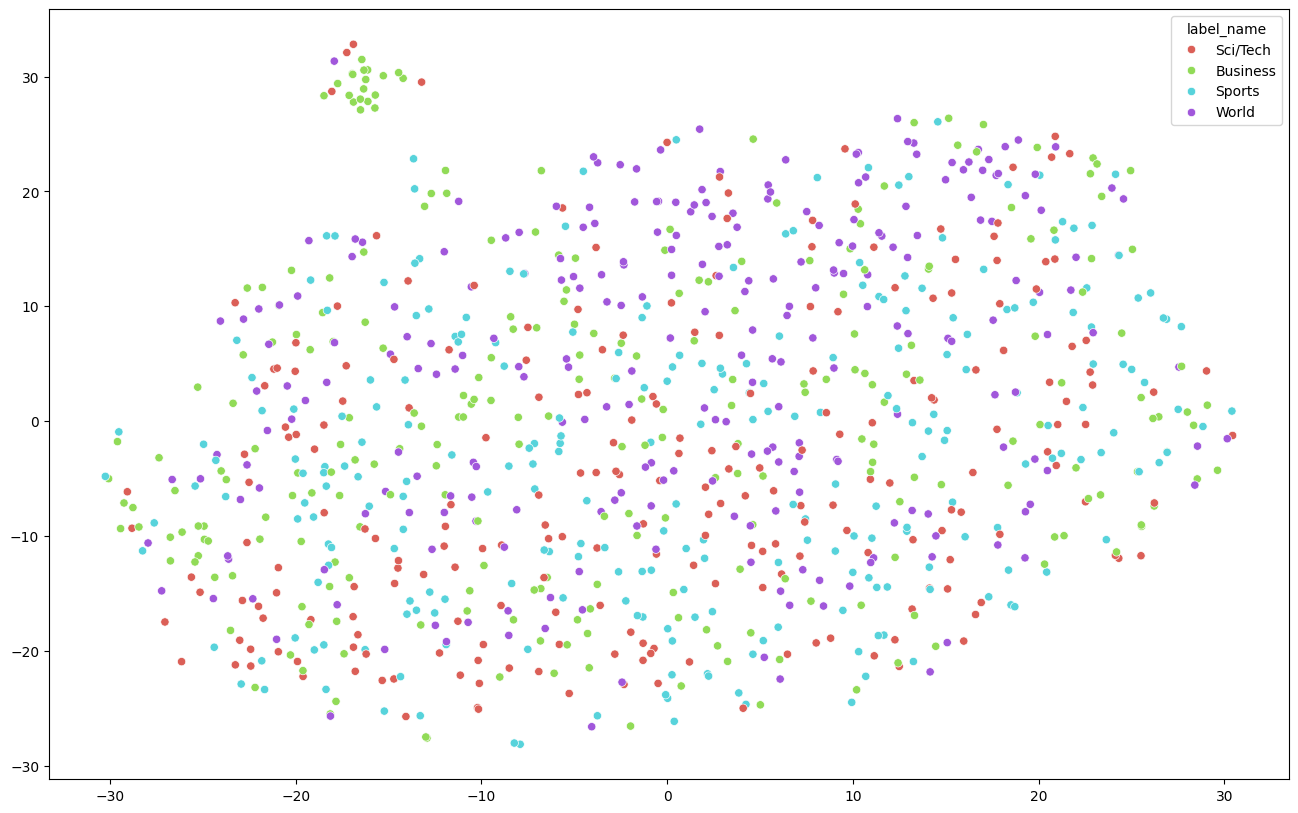

In [20]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=traindf.label_name,
    palette=sns.color_palette("hls", 4),
    legend="full")

Word2Vec is a self-supervised learning of words represenations. Thus all words representations are meaningfull and have an equal impact when computing the mean.  This means that category irrelevant words have an equal importance in the document average represenatation than other words more related to the category.  
Computing the average of word embeddings learned with self-supervised learning is not very efficient for document classification.  
In the following we will see two alternatives using deep neural networks:


1.   Learn our word embeddings at the same time as we learn the classification function
2.   Replace the mean by a recurrent layer responsible for filtering informative words within the sequence



In this section, we will harness the flexibility of PyTorch to work with word embeddings.   
First, we'll proceed by downloading the dataset and preparing it to be compatible with PyTorch.

In [21]:
!pip install datasets

In [22]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]

print(train_data[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


We will use a very basic home-made tokenizer that will remove punctuation and convert the text to lowercase.  
The code provided below will tokenize our text data and establish the necessary vocabulary required for our embedding layers.

In [23]:
import string
from collections import Counter

def simple_tokenizer(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text.strip().split()

train_data = train_data.map(lambda x: {"tokens": simple_tokenizer(x["text"])})
test_data = test_data.map(lambda x: {"tokens": simple_tokenizer(x["text"])})

# Build vocabulary
def yield_tokens(data):
    for example in data:
        yield example["tokens"]


counter = Counter()
for tokens in yield_tokens(train_data):
    counter.update(tokens)

specials = ["<unk>"]
itos = specials + [word for word, freq in counter.items() if freq >= 2]
stoi = {word: idx for idx, word in enumerate(itos)}

We will also load the GloVe embeddings for later.

In [24]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_glove_embeddings(path, vocab, embedding_dim):
    glove_embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_embeddings[word] = vector

    weights_matrix = torch.randn(len(vocab), embedding_dim)
    for word, idx in vocab.items():
        if word in glove_embeddings:
            weights_matrix[idx] = glove_embeddings[word]
    return weights_matrix

embedding_dim = 100
glove_path = "glove.6B.100d.txt"  # Make sure this file is downloaded
weights_matrix = load_glove_embeddings(glove_path, stoi, embedding_dim)

The following method converts a text in tokens.

In [25]:
def process_text(text):
    tokens = simple_tokenizer(text)
    return torch.tensor([stoi.get(token, stoi["<unk>"]) for token in tokens], dtype=torch.int64)


process_text("here is the an example")

tensor([1670,  155,    7,   78, 2410])

# Creating a Custom DataLoader for Texts

In this section, we will set up a custom DataLoader for our text data. This involves some advanced PyTorch techniques. If you prefer to skip the details and proceed directly, you can safely run the next cell, which provides a custom DataLoader. However, if you're interested in understanding what's happening under the hood, here's what we're doing:

**Understanding `collate_fn` in DataLoader:**

Before your data is fed into your model for training or inference, it goes through a crucial function called `collate_fn`. Here's what you need to know about it:

- **Batch Processing**: DataLoader groups your data into batches, where each batch contains a specified number of data samples. The input to `collate_fn` is one of these batches.

- **Data Processing Pipelines**: Prior to using DataLoader, you typically create data processing pipelines to convert your raw data into a format suitable for your model. `collate_fn` is responsible for applying these transformations to each batch of data.

- **Top-Level Function**: It's essential to define `collate_fn` as a top-level Python function, not nested within other functions. This ensures that the function is accessible to all worker processes, which is crucial for parallel processing.

Additionally, as we create our custom DataLoader, we will keep track of the length of each text. This information will be useful later when we use an RNN (Recurrent Neural Network) for processing sequences of varying lengths.


In [26]:
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def text_to_tensor(tokens):
    return torch.tensor([stoi.get(token, stoi["<unk>"]) for token in tokens], dtype=torch.int64)

# Collate Function for DataLoader
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for example in batch:
        label = example["label"]
        tokens = example["tokens"]
        tensor = text_to_tensor(tokens)
        label_list.append(label)
        text_list.append(tensor)
        lengths.append(len(tensor))
    text_tensor = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    label_tensor = torch.tensor(label_list, dtype=torch.int64)
    lengths_tensor = torch.tensor(lengths, dtype=torch.int64)
    return text_tensor.to(device), label_tensor.to(device), lengths_tensor.to(device)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

Let's check that the DataLoader is working as expected.

In [27]:
for batch_texts, batch_labels, batch_lengths in train_loader:
    print(batch_texts.shape, batch_labels.shape, batch_lengths.shape)
    break

torch.Size([8, 48]) torch.Size([8]) torch.Size([8])


# Designing Our Neural Network Classifier

Using PyTorch for embeddings provides us with greater flexibility and control over the embedding process. This allows us to tailor embeddings to our specific needs and integrate them seamlessly into deep learning models for various natural language processing tasks.

Now, let's design our neural network classifier for text classification. The model consists of several key components:

1. **Embedding Layer**: The initial layer of the model is an embedding layer that converts tokens into learnable embeddings. These embeddings capture the semantic meaning of words in our text data.  
Here we will let the possibility to use pre-trained GloVe representations without modifying them to compare the performance obtained with custom embeddings or GloVe.

2. **Mean Pooling**: Similar to our previous approach with Gensim, we will compute the mean of all the token embeddings within the text to create a global text embedding. This global representation captures the overall content of the text.

3. **Linear Layer**: A linear layer will follow, which takes the global text embedding as input and predicts the class label according to this representation.



In [28]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, use_pre_trained=False):
        super(TextClassificationModel, self).__init__()
        if use_pre_trained:
          self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=True)
        else:
          self.embedding = nn.Embedding(vocab_size, embed_dim)

        # self.embedding.weight.requires_grad = False
        self.fc = nn.Linear(embed_dim, num_class)

    def get_embeddings(self, text):
        embedded = self.embedding(text)
        return torch.mean(embedded, 1)

    def forward(self, text):
        embedded = self.get_embeddings(text)
        return self.fc(embedded)

Complete the following training and testing functions.

In [29]:
from tqdm.notebook import tqdm

def train(model, dataloader, optimizer, criterion, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t = tqdm(dataloader)
    for i, (text, labels, text_lengths) in enumerate(t):

      pred = model(text) #convert to 1D tensor
      loss = criterion(pred, labels)

      _, predicted = pred.max(1)
      running_corrects += predicted.eq(labels).sum().item()
      total += labels.size(0)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      t.set_description(f"epoch:{epoch} loss: {(running_loss / (i+1)):.4f} current accuracy:{round(running_corrects / total * 100, 2)}%")

def test(model, dataloader):
    model.eval()
    test_corrects = 0
    total = 0
    with torch.no_grad():
        for text, labels, text_lengths in dataloader:
            pred = model(text)
            _, predicted = pred.max(1)
            test_corrects += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return test_corrects / total

Now compare the performance of this neural classifier when using pre-trained GloVe embeddings or embeddings computed from scratch.

In [31]:
LR = 0.005
num_class = 4
vocab_size = len(itos)
embedding_dim = 100
device = 'cuda'
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, train_loader, optimizer, criterion, epochs=3)
test(model, test_loader)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

0.9160526315789473

In [33]:
model = TextClassificationModel(vocab_size, embedding_dim, num_class, True).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, train_loader, optimizer, criterion, epochs=3)
test(model, test_loader)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

0.8755263157894737

On the test set, get the embeddings of each text and plot them using a t-SNE.

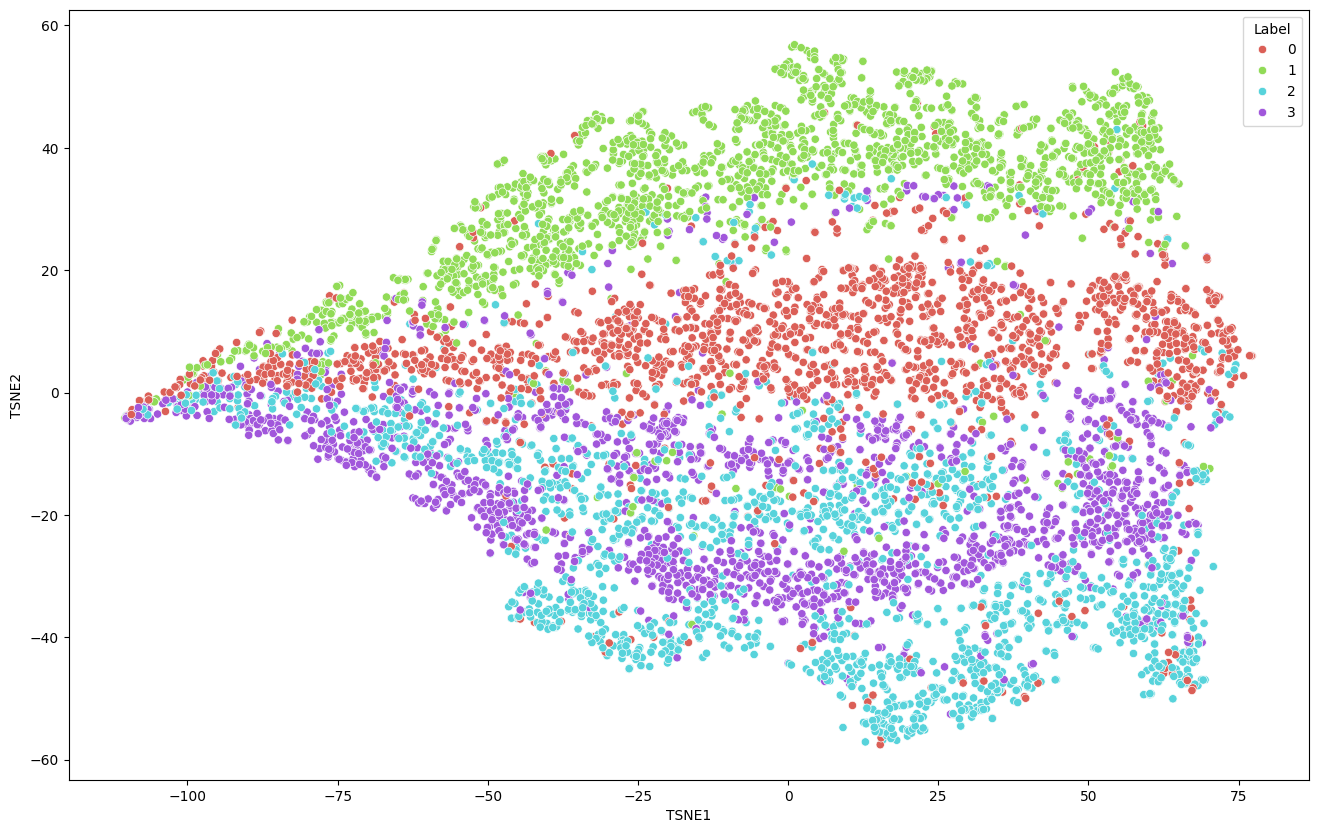

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

embeddings, labels = [], []
for texts, label, _ in test_loader:
    with torch.no_grad():
        embeddings.append(model.get_embeddings(texts).cpu().numpy())
        labels.extend(label.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

X_tsne = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plot_data = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'Label': labels})
plt.figure(figsize=(16, 10))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Label", palette=sns.color_palette("hls", len(np.unique(labels))), data=plot_data, legend="full")
plt.show()


# Adding Recurrence with LSTM Layers

To enhance our network's capacity for understanding sequential data, we will incorporate [LSTM layers](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) into our model. The following code snippet implements a recurrent neural network (RNN) using LSTM layers.

A subtlety in this implementation lies in the use of the `pack_padded_sequence` method. This method is employed to handle sequences of varying lengths. Since not all sequences within a batch have the same length, we need to create "fake" empty tokens to ensure that all elements within a batch have the same dimension. This is precisely what the `pack_padded_sequence` method accomplishes.

Additionally, we'll use the last hidden representation of the LSTM as the embedding for the global text representation.

Furthermore, it's crucial to note that, since we need to send the lengths of the texts to the model, we will have to include this information within the `forward` method. This modification will also necessitate adjustments in our training and testing methods.


In [ ]:
import torch.nn as nn

class TextClassifier(nn.Module):

  def __init__(self, vocab_size, embedding_dim, output_dim=4):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, sparse=True)
    self.lstm = nn.LSTM(embedding_dim,
                        100,
                        num_layers=2,
                        dropout=0.2,
                        batch_first=True)
    self.fc = nn.Linear(100, output_dim)

  def forward(self, text, text_lengths):
      embedded = self.get_embeddings(text, text_lengths)
      outputs=self.fc(embedded)
      return outputs


  def get_embeddings(self, text, text_lengths):
      embedded = self.embedding(text)
      #packed sequence
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
      _, (hidden, cell) = self.lstm(packed_embedded)
      return hidden[-1]

In [ ]:
def train(model, dataloader, optimizer, criterion, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t = tqdm(dataloader)
    for i, (text, labels, text_lengths) in enumerate(t):

      pred = model(text, text_lengths).squeeze() #convert to 1D tensor
      loss = criterion(pred, labels)

      _, predicted = pred.max(1)
      running_corrects += predicted.eq(labels).sum().item()
      total += labels.size(0)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      t.set_description(f"epoch:{epoch} loss: {(running_loss / (i+1)):.4f} current accuracy:{round(running_corrects / total * 100, 2)}%")

  def test(model, dataloader):
    model.eval()
    test_corrects = 0
    total = 0
    with torch.no_grad():
        for text, labels, text_lengths in dataloader:
            pred = model(text, text_lengths).squeeze()
            _, predicted = pred.max(1)
            test_corrects += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return test_corrects / total

Train a reccurent model.

In [ ]:
model = TextClassifier(vocab_size, 64, 4).to(device).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
train(model, train_loader, optimizer, criterion, epochs=5)
test(model, test_loader)

Plot the corresponding representatons on a t-SNE.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

embeddings, labels = [], []
for texts, label, text_lengths in test_loader:
    with torch.no_grad():
        embeddings.append(model.get_embeddings(texts, text_lengths).cpu().numpy())
        labels.extend(label.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

X_tsne = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plot_data = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'Label': labels})
plt.figure(figsize=(16, 10))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Label", palette=sns.color_palette("hls", len(np.unique(labels))), data=plot_data, legend="full")
plt.show()